# Проект «Выбор локации для скважины»

### Описание задачи

Мы работаем в добывающей компании «ГлавРосГосНефть».

Нам необходимо решить, где бурить новую скважину.

#### Постановка задачи

Нам предоставлены пробы нефти в трех регионах.
Характеристики для каждой скважины уже известны.
Необходимо построить модель для определения региона, где добыча принесет наибольшую прибыль, а также проанализировать возможную прибыль
и риски техникой Bootstrap.

### Описание данных

Данные геологоразведки трех регионов находятся в трех датасетах (geo_data_N.csv, где N = 0, 1, 2), в которых:
* id — уникальный идентификатор скважины
* f0, f1, f2 — три признака точек
* product — объем запасов в скважине (тыс. баррелей)

#### Условия задачи

* Для обучения модели подходит только линейная регрессия.
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
# Примечание: в новой версии библиотеки sklearn вычисление RMSE будет производится иначе (не как указано в теории)
# На всякий случай, добавил оба варианта.

In [3]:
try:
    from sklearn.metrics import mean_squared_error
except:
    from sklearn.metrics import root_mean_squared_error

In [4]:
RANDOM_STATE = 12345

## Загрузка данных

In [5]:
filename_1 = 'geo_data_0.csv'
filename_2 = 'geo_data_1.csv'
filename_3 = 'geo_data_2.csv'

In [6]:
try:
    data_1 = pd.read_csv('/datasets/' + filename_1)
except:
    data_1 = pd.read_csv(filename_1)

In [7]:
try:
    data_2 = pd.read_csv('/datasets/' + filename_2)
except:
    data_2 = pd.read_csv(filename_2)

In [8]:
try:
    data_3 = pd.read_csv('/datasets/' + filename_3)
except:
    data_3 = pd.read_csv(filename_3)

#### Осмотр данных

Посмотрим на датасеты

##### data_1

In [2]:
data_1.info()

NameError: name 'data_1' is not defined

Видим, что датасет полный (без NaN'ов).
Отметим, что индексы имеют тип object, т.е. строковый, а не числовой.

Посмотрим на первые 5 строк датасета.

In [10]:
data_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Датасет загрузился корректно.

##### data_2

In [11]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датасет полный (без NaN'ов).
Индексы также имеют строковый тип.

Посмотрим на первые 5 строк.

In [12]:
data_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Датасет загрузился корректно.

##### data_3

In [13]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датасет полный (без NaN'ов).
Индексы имеют строковый тип.

Посмотрим на первые 5 строк.

In [14]:
data_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Датасет загрузился корректно.

## Предобработка данных

Проверим данные на дубликаты

In [15]:
data_1.duplicated().sum()

np.int64(0)

In [16]:
data_2.duplicated().sum()

np.int64(0)

In [17]:
data_3.duplicated().sum()

np.int64(0)

Дубликатов в данных нет.

## Анализ данных

Посмотрим на описательную статистику признака product («объем запасов в скважине») во всех трех датасетах.

In [18]:
pd.DataFrame({'data_1': data_1['product'], \
              'data_2': data_2['product'], \
              'data_3': data_3['product']}).describe()

,data_1,data_2,data_3
count,100000.000000,100000.000000,100000.000000
mean,92.500000,68.825000,95.000000
std,44.288691,45.944423,44.749921
min,0.000000,0.000000,0.000000
25%,56.497507,26.953261,59.450441
50%,91.849972,57.085625,94.925613
75%,128.564089,107.813044,130.595027
max,185.364347,137.945408,190.029838


Видим, что аномальных значений и выбросов нет (минимальные и максимальные значения лежат в пределах «усов»).

Изучим их распределения.

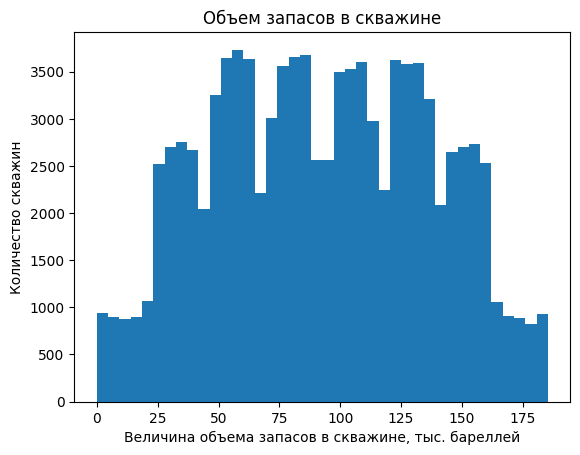

In [19]:
data_1['product'].plot(kind='hist',
                       bins=40, \
                       xlabel='Величина объема запасов в скважине, тыс. бареллей', \
                       ylabel='Количество скважин', title='Объем запасов в скважине');

Мы видим, что распределение симметрично.
Наблюдается группировка количества скважин относительно некоторых величин объема запасов, в результате чего образуются пики
в распределении.
В целом, если рассмотреть весь спектр объема запасов в скважине, то найдется скважина практически любого объема.

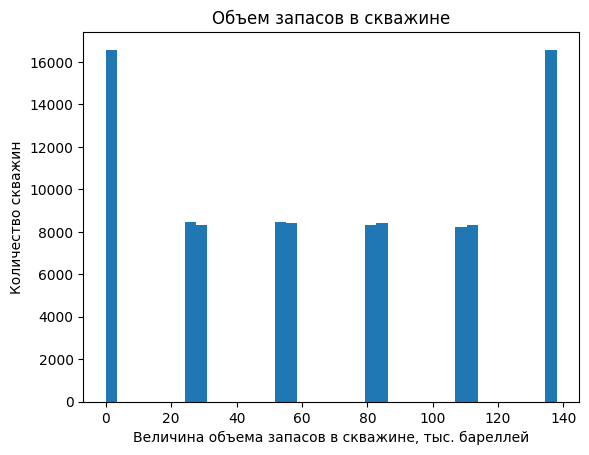

In [20]:
data_2['product'].plot(kind='hist',
                       bins=40, \
                       xlabel='Величина объема запасов в скважине, тыс. бареллей', \
                       ylabel='Количество скважин', title='Объем запасов в скважине');

Мы видим, что характер распределения существенно отличается от первого региона: здесь мы наблюдаем регулярные и достаточно большие разрывы
в наличии скважин определенных запасов.
Скважины с наличествующими запасами сгруппированы и отстоят друг от друга на сравнительно равные промежутки по величине объема запасов.
Кроме того, видим, что очень много скважин с минимаальным запасами, но примерно столько же скважин и с максимальными запасами, так что
суммарно наблюдается средняя картина.

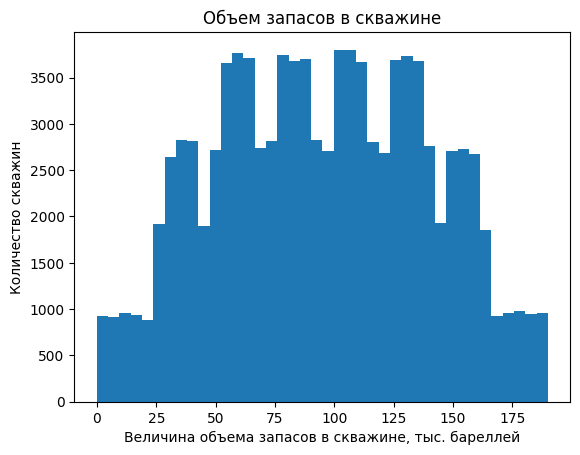

In [21]:
data_3['product'].plot(kind='hist',
                       bins=40, \
                       xlabel='Величина объема запасов в скважине, тыс. бареллей', \
                       ylabel='Количество скважин', title='Объем запасов в скважине');

Мы видим, что характер распределения такой же, как и в первом регионе — симметричное распределение с небольшими группировками вокруг
некоторых значений.

В целом, мы видим, что характер распределения объема во втором регионе сильно отличается от такового в первом и третьем регионах (где характер распределения более-менее одинаков).
Возможно, второй регион находится в другой географической области относительно первого и третьего регионов, либо это локальные особенности конкретной местности.

## Обучение и проверка модели

### Подготовка данных

Сохраним столбцы с признаками:

In [22]:
feature_cols = ['f0', 'f1', 'f2']

#### Первый регион

Выделим целевой признак product («объем запасов в скважине»).
Разделим выборки на обучающую и валидационную в соотношении 75:25

In [23]:
X = data_1[feature_cols]
y = data_1['product']

In [24]:
X_train, X_valid, y_train_1, y_valid_1 = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

Категориальных признаков у нас нет, поэтому остается только масштабирование числовых признаков.

Масштабируем признаки

In [25]:
scaler = StandardScaler()

In [26]:
X_train_scaled = scaler.fit_transform(X_train[feature_cols])
X_valid_scaled = scaler.transform(X_valid[feature_cols])

In [27]:
X_train_1 = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_valid_1 = pd.DataFrame(X_valid_scaled, columns=feature_cols)

Выборки готовы

#### Второй регион

Выделим целевой признак product («объем запасов в скважине»).
Разделим выборки на обучающую и валидационную в соотношении 75:25

In [28]:
X = data_2[feature_cols]
y = data_2['product']

In [29]:
X_train, X_valid, y_train_2, y_valid_2 = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

Масштабируем признаки

In [30]:
scaler = StandardScaler()

In [31]:
X_train_scaled = scaler.fit_transform(X_train[feature_cols])
X_valid_scaled = scaler.transform(X_valid[feature_cols])

In [32]:
X_train_2 = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_valid_2 = pd.DataFrame(X_valid_scaled, columns=feature_cols)

Выборки готовы

#### Третий регион

Выделим целевой признак product («объем запасов в скважине»).
Разделим выборки на обучающую и валидационную в соотношении 75:25

In [33]:
X = data_3[feature_cols]
y = data_3['product']

In [34]:
X_train, X_valid, y_train_3, y_valid_3 = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

Масштабируем признаки

In [35]:
scaler = StandardScaler()

In [36]:
X_train_scaled = scaler.fit_transform(X_train[feature_cols])
X_valid_scaled = scaler.transform(X_valid[feature_cols])

In [37]:
X_train_3 = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_valid_3 = pd.DataFrame(X_valid_scaled, columns=feature_cols)

Выборки готовы

### Обучение и проверка

#### Первый регион

Инициализируем, обучаем модель линейной регрессии.
Получаем предсказание.

In [38]:
model_lr = LinearRegression()

In [39]:
model_lr.fit(X_train_1, y_train_1);

In [40]:
y_pred_1 = model_lr.predict(X_valid_1)

Сохраним полученный результат вместе с индексами для корректного соотнесения конкретных скважин с ими же из валидационной выборки.

In [41]:
y_pred_1 = pd.Series(y_pred_1, y_valid_1.index, name='product')

##### Средний запас предсказанного сырья и RMSE модели

In [42]:
# Примечание: в новой версии библиотеки sklearn вычисление RMSE будет производится иначе (не как указано в теории)
# На всякий случай, добавил оба варианта.

In [43]:
try:
    rmse = mean_squared_error(y_valid_1, y_pred_1, squared=False)
except:
    rmse = root_mean_squared_error(y_valid_1, y_pred_1)

print('Средний запас предсказанного сырья', round(y_pred_1.mean(), 6))
print('RMSE модели', rmse)

Средний запас предсказанного сырья 92.592568
RMSE модели 37.5794217150813


/usr/lib64/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Мы видим, что средний запас предсказанного сырья составляет 92.6 тыс. баррелей.
При этом у модели достаточно высокий RMSE.

#### Второй регион

Обучаем модель линейной регрессии.
Получаем предсказание.

In [44]:
model_lr.fit(X_train_2, y_train_2);

In [45]:
y_pred_2 = model_lr.predict(X_valid_2)

Сохраним полученный результат вместе с индексами для корректного соотнесения конкретных скважин с ими же из валидационной выборки.

In [46]:
y_pred_2 = pd.Series(y_pred_2, y_valid_2.index, name='product')

##### Средний запас предсказанного сырья и RMSE модели

In [47]:
# Примечание: в новой версии библиотеки sklearn вычисление RMSE будет производится иначе (не как указано в теории)
# На всякий случай, добавил оба варианта.

In [48]:
try:
    rmse = mean_squared_error(y_valid_2, y_pred_2, squared=False)
except:
    rmse = root_mean_squared_error(y_valid_2, y_pred_2)

print('Средний запас предсказанного сырья', round(y_pred_2.mean(), 6))
print('RMSE модели', rmse)

Средний запас предсказанного сырья 68.728547
RMSE модели 0.893099286775617


/usr/lib64/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Мы видим, что средний запас предсказанного сырья во втором регионе существенно меньше такового в первом, но RMSE модели очень низкий — модель
хорошо предсказывает запасы.

#### Третий регион

Обучаем модель линейной регрессии.
Получаем предсказание.

In [49]:
model_lr.fit(X_train_3, y_train_3);

In [50]:
y_pred_3 = model_lr.predict(X_valid_3)

Сохраним полученный результат вместе с индексами для корректного соотнесения конкретных скважин с ими же из валидационной выборки.

In [51]:
y_pred_3 = pd.Series(y_pred_3, y_valid_3.index, name='product')

##### Средний запас предсказанного сырья и RMSE модели

In [52]:
# Примечание: в новой версии библиотеки sklearn вычисление RMSE будет производится иначе (не как указано в теории)
# На всякий случай, добавил оба варианта.

In [53]:
try:
    rmse = mean_squared_error(y_valid_3, y_pred_3, squared=False)
except:
    rmse = root_mean_squared_error(y_valid_3, y_pred_3)

print('Средний запас предсказанного сырья', round(y_pred_3.mean(), 6))
print('RMSE модели', rmse)

Средний запас предсказанного сырья 94.965046
RMSE модели 40.02970873393434


/usr/lib64/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Мы видим, что средний запас предсказанного сырья в первом и третьем регионах примерно одинаков (92.6 и 95.0 тыс. баррелей), равно как и RMSЕ у обоих моделей довольно высокий (37.6 и 40 соответственно) — картина похожая.
Во втором же регионе средний запас предсказанного сырья существенно ниже — всего 68.7 тыс. баррелей, но RMSE модели очень низкий (0.89).

Изучим вопрос об экономической целесообразности разработки месторождений в регионах.

### Расчет прибыли

#### Подготовка

Ключевые значения для расчетов сохраним в отдельных переменных:

In [54]:
# Бюджет на разработку скважин в регионе
WELL_DEV_REG_BUDGET = 10_000_000_000

# Доход с единицы продукта (т.е. с 1 тыс. баррелей)
PROD_UNIT_INCOME = 450_000

# Количество исследуемых скважин в регионе
NUM_OF_WELLS_TO_RESEARCH = 500

# Количество разрабатываемых скважин в регионе
NUM_OF_WELLS_TO_DEV = 200

# Вероятность убытков
LOSS_PROB_THRESHOLD = 0.025

Для того чтобы разработка скважины была безубыточной, доход от запаса сырья в ней не должен быть меньше бюджета на
разработку этой скважины.
Для расчета такого минимального запаса сырья необходимо бюджет на разработку одной скважины разделить на доход с единицы продукта.

In [55]:
well_min_capacity = WELL_DEV_REG_BUDGET / NUM_OF_WELLS_TO_DEV / PROD_UNIT_INCOME
print(f'Объем минимального запаса сырья в скважине для ее безубыточной разработки: {round(well_min_capacity, 6)} тыс. баррелей')

Объем минимального запаса сырья в скважине для ее безубыточной разработки: 111.111111 тыс. баррелей


Если взглянуть на описательную статистику распределения признака product («объем запасов в скважине») для всех регионов (содержится в исследовательском анализе данных), то
мы видим, что объем минимального запаса для безубыточной разработки выше средних величин запаса для каждой из скважин (92.5, 68.825, 95.0 тыс. баррелей соответственно).
Кроме того, из описательной статистики, а также графического распределения запасов в этих регионах, мы видим, что в каждом из регионов достаточно много скважин с запасом выше рассчитанного выше требуемого минимума запаса (в первом и третьем регионах таких скважин более $25\%$, т.к. $75\%$-квантиль больше рассчитанного минимума).
Для второго региона таких скважин, по крайней мере, больше $16\%$, т.к. скважин с запасом выше 120 тыс. баррелей точно больше 16000 из 100000,— это видно из графического распределения. При этом для второго региона, как мы помним, характерно довольно более высокое качество прогноза.

#### Расчет

Функция для расчета прибыли по выбранным скважинам и предсказаниям модели:

In [56]:
def get_profit(y_pred, y_valid):
    y_pred.reset_index(drop=True, inplace=True)
    y_valid.reset_index(drop=True, inplace=True)
    
    return y_valid[y_pred.sort_values(ascending=False)[:NUM_OF_WELLS_TO_DEV].index] \
        .sum()*PROD_UNIT_INCOME - WELL_DEV_REG_BUDGET

Рассчитаем прибыль по выбранным скважинам в каждом из регионов:

In [57]:
print(f'Прибыль по выбранным скважинам в первом регионе составляет {round(get_profit(y_pred_1, y_valid_1) / 1_000_000, 2)} млн. руб.')

Прибыль по выбранным скважинам в первом регионе составляет 3320.83 млн. руб.


In [58]:
print(f'Прибыль по выбранным скважинам во втором регионе составляет {round(get_profit(y_pred_2, y_valid_2) / 1_000_000, 2)} млн. руб.')

Прибыль по выбранным скважинам во втором регионе составляет 2415.09 млн. руб.


In [59]:
print(f'Прибыль по выбранным скважинам в третьем регионе составляет {round(get_profit(y_pred_3, y_valid_3) / 1_000_000, 2)} млн. руб.')

Прибыль по выбранным скважинам в третьем регионе составляет 2710.35 млн. руб.


### Распределение прибыли и расчет рисков

Функция для получения распределения прибыли техникой Bootstrap

In [60]:
state = np.random.RandomState(RANDOM_STATE)
def get_profit_distrib(y_pred, y_valid):
    profit_distrib = []
    for i in range(1000):
        y_pred_sample = y_pred.sample(n=NUM_OF_WELLS_TO_RESEARCH, replace=True, random_state=state)
        y_valid_sample = y_valid[y_pred_sample.index]
        
        profit_distrib.append(get_profit(y_pred_sample, y_valid_sample))

    return pd.Series(profit_distrib, name='profit')

Получим распределение прибыли для всех трех регионов

In [61]:
profit_distrib_1 = get_profit_distrib(y_pred_1, y_valid_1)

In [62]:
profit_distrib_2 = get_profit_distrib(y_pred_2, y_valid_2)

In [63]:
profit_distrib_3 = get_profit_distrib(y_pred_3, y_valid_3)

#### Первый регион

##### Средняя прибыль

In [64]:
print(f'Средняя прибыль при разработке первого региона: {round(profit_distrib_1.mean() / 1_000_000, 2)} млн. руб.')

Средняя прибыль при разработке первого региона: 396.16 млн. руб.


##### Доверительный интервал

In [65]:
print(f'95% доверительный интервал: ({round(np.quantile(profit_distrib_1, 0.025) / 1_000_000, 2)}, '
      f'{round(np.quantile(profit_distrib_1, 0.975) / 1_000_000, 2)}) млн. руб.')

95% доверительный интервал: (-111.22, 909.77) млн. руб.


##### Риск убытков

Рассчитаем риск как долю скважин с отрицательной прибылью (в процентах)

In [66]:
print(f'Риск убытков при разработке первого региона: {len(profit_distrib_1[profit_distrib_1 < 0]) / len(profit_distrib_1) * 100} %')
print(f'Пороговое значение риска убытков: {LOSS_PROB_THRESHOLD * 100} %')

Риск убытков при разработке первого региона: 6.9 %
Пороговое значение риска убытков: 2.5 %


Видим, что в первом регионе риск убытков выше порогового значения.
Т.к. необходимо оставить регионы с риском убытков строго ниже порогового значения, первый регион в дальнейшем рассматриваться не будет.

#### Второй регион

##### Средняя прибыль

In [67]:
print(f'Средняя прибыль для второго региона: {round(profit_distrib_2.mean() / 1_000_000, 2)} млн. руб.')

Средняя прибыль для второго региона: 461.16 млн. руб.


##### Доверительный интервал

In [68]:
print(f'95% доверительный интервал: ({round(np.quantile(profit_distrib_2, 0.025) / 1_000_000, 2)}, ' 
    f'{round(np.quantile(profit_distrib_2, 0.975) / 1_000_000, 2)}) млн. руб.')

95% доверительный интервал: (78.05, 862.95) млн. руб.


##### Риск убытков

In [69]:
print(f'Риск убытков при разработке первого региона: {len(profit_distrib_2[profit_distrib_2 < 0]) / len(profit_distrib_2) * 100} %')
print(f'Пороговое значение риска убытков: {LOSS_PROB_THRESHOLD * 100} %')

Риск убытков при разработке первого региона: 0.7000000000000001 %
Пороговое значение риска убытков: 2.5 %


Видим, что риск убытков для второго региона низкий и ниже порогового значения.

#### Третий регион

##### Средняя прибыль

In [70]:
print(f'Средняя прибыль для третьего региона: {round(profit_distrib_3.mean() / 1_000_000, 2)} млн. руб.')

Средняя прибыль для третьего региона: 392.95 млн. руб.


##### Доверительный интервал

In [71]:
print(f'95% доверительный интервал: ({round(np.quantile(profit_distrib_3, 0.025) / 1_000_000, 2)}, '
      f'{round(np.quantile(profit_distrib_3, 0.975) / 1_000_000, 2)}) млн. руб.')

95% доверительный интервал: (-112.23, 934.56) млн. руб.


##### Риск убытков

In [72]:
print(f'Риск убытков при разработке первого региона: {len(profit_distrib_3[profit_distrib_3 < 0]) / len(profit_distrib_3) * 100} %')
print(f'Пороговое значение риска убытков: {LOSS_PROB_THRESHOLD * 100} %')

Риск убытков при разработке первого региона: 6.5 %
Пороговое значение риска убытков: 2.5 %


Видим, что для третьего риск убытков выше порогового значения.
Т.к. необходимо оставить регионы с риском строго ниже порогового значения, то третий регион в дальнейшем нами рассматриваться не будет.

В итоге, для разработки месторождений предлагается выбрать второй регион, т.к., в сравнении с остальными, у него риск убытков ниже порогового значения.
Кроме того, у него неплохая средняя прибыль.

### Общий вывод

Был проведен анализ данных и получены следующие результаты:

На этапе осмотра и предобработки данных аномалий и дубликатов не обнаружено.

В ходе исследовательского анализа выявлен схожий характер распределения объемов запасов скважин в первом и третьем регионах.
Во втором регионе характер распределения принципиально другой, возможно, это связано с размещением второго региона в другой географической
области.

Была обучена модель линейной регрессии для каждого региона, получены предсказания объемов запасов для них.
Средний запас предсказанного сырья в первом и третьем регионах примерно одинаков (92.6 и 95.0 тыс. баррелей), равно как и RMSЕ у обоих моделей довольно высокий (37.6 и 40 соответственно) — картина похожая.
Во втором же регионе средний запас предсказанного сырья существенно ниже — всего 68.7 тыс. баррелей, но RMSE модели очень низкий (0.89).

Был рассчитан минимальный объем сырья в скважине необходимый для ее безубыточной разработки.
Оказалось, что этот объем выше среднего объема запасов в скважинах для каждого из регионов.
При этом, мы увидели, что в каждом из регионов есть достаточно количество скважин с требуемым запасом.

Была написана функция расчета прибыли по выбранным скважинам и предсказаниям модели и рассчитана прибыль для полученного объема сырья.

Техникой Bootstrap было найдено распределение прибыли для каждого из регионов.
Были получена средняя прибыль, $95\%$-й доверительный интервал и риск убытков для каждого из регионов.
Выяснилось, что для первого и третьего регионов риск убытков выше порогового значения, соответственно, эти регионы для разработки
рассматриваться не могут. Поэтому для разработки предлагается выбрать второй регион.